<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

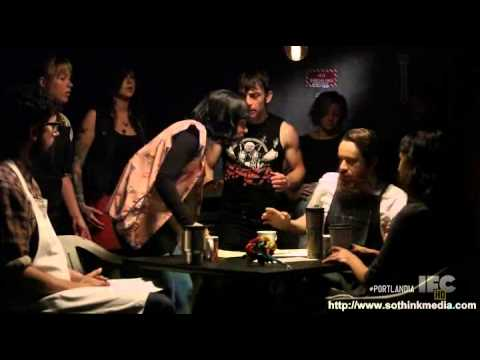

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/alexanderbennett/Desktop/repos/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
# Start here
# I want the star rating to just be an integer
shops['star_rating'] = shops['star_rating'].str[1].astype(int)
shops['star_rating'].head()

0    5
1    4
2    4
3    2
4    4
Name: star_rating, dtype: int64

In [5]:
shops['full_review_text'] = shops['full_review_text'].str.split("/",expand=True)[2]
shops['full_review_text'] = shops['full_review_text'].str.strip("2014")
shops['full_review_text'] = shops['full_review_text'].str.strip("2015")
shops['full_review_text'] = shops['full_review_text'].str.strip("2016")
shops['full_review_text'] = shops['full_review_text'].str.strip("2017")
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Ev...,5
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the...,4
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Ho...,2
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4


In [6]:
# Voila! got junk out of the full_review_text column. Now doing NLP should be a bit easier.

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [7]:
# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

In [8]:
nlp = spacy.load("en_core_web_lg")
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [9]:
# applying function
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

# checking
shops.head()

,coffee_shop_name,full_review_text,star_rating,lemmas
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Ev...,5,"[ , 1, check, Love, love, love, atmosphere, co..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4,"[ , list, Date, Night, Austin, Ambiance, Austi..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the...,4,"[ , 1, check, list, Brunch, Spots, love, eclec..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Ho...,2,"[ , cool, decor, good, drink, nice, seating, ..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northc...,4,"[ , 1, check, locate, Northcross, mall, shoppi..."


In [10]:
#  instantiating tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [11]:
tokens = []

"""taking stopword out of tokens"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [12]:
# these are the stopwords
STOP_WORDS = nlp.Defaults.stop_words

In [13]:
# Obtaining a counter from python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

In [14]:
# making a function to get the word count
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

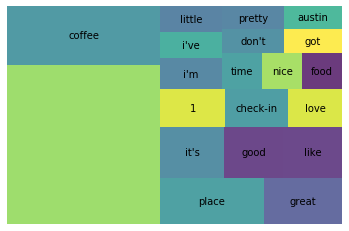

In [15]:
# Use the Function to get wordcount
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [16]:
STOP_WORDS = nlp.Defaults.stop_words.union(["coffee","shop","austin","got","time"," ","I've","1","it's","-","i'm","i've"])

In [17]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

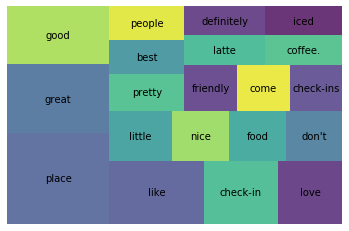

In [18]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [19]:
shops['star_rating'] = shops['star_rating'].astype(float)

In [20]:
# separating shops based on star rating
good_shops = shops[shops['star_rating']>4]
bad_shops = shops[shops['star_rating']<2]

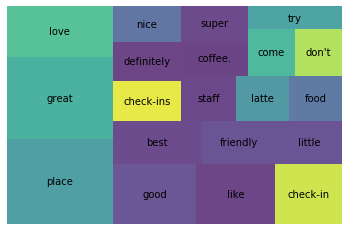

In [21]:
wc = count(good_shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

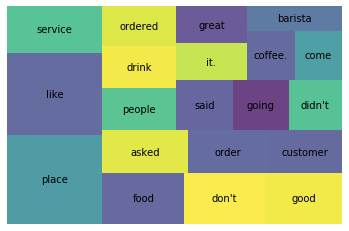

In [22]:
wc = count(bad_shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [23]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
good_word_counts = Counter()

# Update it based on a split of each of our documents
good_shops['tokens'].apply(lambda x: good_word_counts.update(x))

# Print out the 10 most common words
good_word_counts.most_common(50)

[('place', 1772),
 ('great', 1739),
 ('love', 1056),
 ('good', 1006),
 ('like', 942),
 ('check-in', 803),
 ('best', 758),
 ('friendly', 630),
 ('little', 565),
 ('check-ins', 549),
 ('definitely', 528),
 ('nice', 492),
 ('staff', 490),
 ('latte', 482),
 ('food', 479),
 ('coffee.', 464),
 ('super', 458),
 ('come', 437),
 ("don't", 432),
 ('try', 431),
 ('iced', 429),
 ('people', 425),
 ('favorite', 420),
 ('delicious', 410),
 ('breakfast', 409),
 ('coffee,', 393),
 ('work', 388),
 ('gelato', 380),
 ('tea', 363),
 ('pretty', 348),
 ('service', 327),
 ('it.', 318),
 ('austin.', 317),
 ('place.', 313),
 ('want', 311),
 ('3', 308),
 ('amazing', 306),
 ('perfect', 306),
 ('drink', 298),
 ('seating', 298),
 ('know', 295),
 ('cream', 290),
 ('sweet', 289),
 ("you're", 289),
 ('parking', 288),
 ('&', 284),
 ('ordered', 283),
 ('new', 281),
 ('spot', 280),
 ('awesome', 279)]

In [24]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
bad_word_counts = Counter()

# Update it based on a split of each of our documents
bad_shops['tokens'].apply(lambda x: bad_word_counts.update(x))

# Print out the 10 most common words
bad_word_counts.most_common(50)

[('place', 146),
 ('like', 134),
 ('service', 76),
 ('food', 71),
 ("don't", 70),
 ('good', 67),
 ('asked', 63),
 ('order', 59),
 ('customer', 55),
 ('people', 54),
 ('drink', 53),
 ('ordered', 50),
 ('said', 49),
 ('going', 48),
 ("didn't", 46),
 ('it.', 45),
 ('great', 45),
 ('coffee.', 41),
 ('come', 40),
 ('barista', 40),
 ('know', 39),
 ('went', 39),
 ('iced', 36),
 ('told', 36),
 ('try', 35),
 ('came', 35),
 ('coffee,', 33),
 ('rude', 33),
 ('guy', 33),
 ('took', 33),
 ('review', 31),
 ('cream', 31),
 ('bad', 30),
 ('counter', 30),
 ('want', 30),
 ('work', 30),
 ('tea', 29),
 ('right', 29),
 ('pretty', 29),
 ('experience', 29),
 ('staff', 29),
 ('getting', 27),
 ('little', 27),
 ('thing', 27),
 ('3', 26),
 ('2', 25),
 ('check-in', 25),
 ('walked', 25),
 ('minutes', 25),
 ("wasn't", 24)]

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [28]:
from collections import Counter

word_counts = Counter()

shops['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('place', 3910),
 ('great', 2966),
 ('good', 2501),
 ('like', 2485),
 ('check-in', 1959),
 ('love', 1677),
 ('little', 1318),
 ('nice', 1209),
 ('food', 1208),
 ("don't", 1183)]

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

